In [2]:
# 3rd party
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Read SHAP scores
test=pd.read_csv('/nobackup/khauskne/kdd/all_shap_scores.csv')

In [4]:
# Read Robovetter Minor Flags
robo_flags=pd.read_csv('/nobackup/khauskne/kdd/robovetter_flags_all_DR25.csv')

In [5]:
robo_flags

,Unnamed: 0,target_id,tce_plnt_num,TCE,Robovetter_Score,Disposition,Not_Transit-Like_Flag,Stellar_Eclipse_Flag,Centroid_Offset_Flag,Ephemeris_Match_Flag,Minor_Descriptive_Flags,Global Flux Flag,Local Flux Flag,Centroid Flag,Odd Even Flag,Secondary Flag,Stellar Flag,DV Flag
0,0,757099,1,000757099-01,0.000,FP,1,0,0,0,LPP_DV---LPP_ALT---MOD_NONUNIQ_DV,0,1,0,0,0,0,0
1,1,757450,1,000757450-01,0.999,PC,0,0,0,0,NO_COMMENT,0,0,0,0,0,0,0
2,2,892376,1,000892376-01,0.000,FP,1,0,0,0,INDIV_TRANS_CHASES_MARSHALL---LPP_DV---ALL_TRA...,0,1,0,0,0,0,0
3,3,892376,2,000892376-02,0.000,FP,1,0,0,0,LPP_DV---MOD_NONUNIQ_DV---CENT_KIC_POS,0,1,0,0,0,0,0
4,4,892376,3,000892376-03,0.000,FP,1,0,0,0,INDIV_TRANS_RUBBLE---TRANS_GAPPED---LPP_DV---L...,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,32529,12885212,1,012885212-01,0.001,FP,0,0,1,0,CENT_RESOLVED_OFFSET,0,0,1,0,0,0,0
32530,32530,12885212,2,012885212-02,0.638,PC,0,0,0,0,NO_COMMENT,0,0,0,0,0,0,0
32531,32531,12885505,1,012885505-01,0.000,FP,1,0,0,0,INDIV_TRANS_MARSHALL---LPP_DV---INCONSISTENT_T...,0,1,0,0,0,0,0
32532,32532,12935144,1,012935144-01,0.000,FP,0,0,1,0,CENT_RESOLVED_OFFSET---HALO_GHOST,0,0,1,0,0,0,1


In [6]:
# Merge Robovetter Minor Flags with SHAP scores
test_csv=pd.merge(test, robo_flags, on=['target_id', 'tce_plnt_num'])

In [7]:
# choose only columns of interest
shap_array=np.array(test_csv[test_csv.columns[4:11]])
robo_array=np.array(test_csv[test_csv.columns[20:]])

In [8]:
def post_process_flags(robo_flags, branch_explanations):
    branch_inds_to_keep=[1,2,3,4,6]
    
    robo_new=np.moveaxis(robo_flags ,0, -1)[branch_inds_to_keep]
    robo_new=np.moveaxis(robo_new, 0, -1)
    
    exp_new=np.moveaxis(branch_explanations, 0, -1)
    global_flux=exp_new[0]
    local_flux=exp_new[1]
    greater_flux=np.amax(test_csv[test_csv.columns[4:6]], axis=1)
    #combined_flux=np.where(added_flux>0, 1, 0)
    exp_new=exp_new[branch_inds_to_keep]
    exp_new[0]=greater_flux
    exp_new=np.moveaxis(exp_new, 0, -1)
    
    return robo_new, exp_new

In [9]:
robo, shap=post_process_flags(robo_array, shap_array)

In [10]:
shap_array

array([[-3.57547000e-11,  6.60000000e-12, -3.46600000e-11, ...,
        -3.57970500e-11, -3.57918700e-11, -3.57908800e-11],
       [-1.43685000e-09, -1.42500000e-09,  1.38600000e-08, ...,
         4.50000000e-09, -1.43999866e-09, -1.44000000e-09],
       [-4.74000000e-10,  2.29800000e-08,  7.08000000e-09, ...,
        -7.22000000e-10, -1.21100000e-09, -1.24070000e-09],
       ...,
       [-2.16104000e-04,  1.05337000e-04,  1.57937000e-03, ...,
        -3.11854000e-04,  1.26875000e-04,  4.69460000e-05],
       [ 3.32000000e-05, -2.67197000e-03, -4.99094000e-03, ...,
        -1.62670000e-04, -1.01460000e-04, -1.16015000e-03],
       [ 1.86810000e-08,  2.04100000e-09,  3.99100000e-09, ...,
        -1.18968500e-10, -5.70000000e-11, -1.11600000e-10]])

In [11]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

In [12]:
def top_n(robo, occlusion_array, n, average_type='weighted'):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[-1*n:]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=precision_score(robo, occlusion, average=average_type)
    weighted_rec=recall_score(robo,occlusion, average=average_type)
    print(str(np.round(weighted_prec, 4))+' \& '+str(np.round(weighted_rec, 4)) )
    return weighted_prec, weighted_rec

In [13]:
top_n(robo_array, shap_array, 1, 'micro')

0.4414 \& 0.4456


(0.44139732288605943, 0.4456163480553724)

In [14]:
top_n(robo_array, shap_array, 1, 'macro')

0.3152 \& 0.3349


(0.3152116115500066, 0.33487916735242707)

In [15]:
top_n(robo_array, shap_array, 1, 'weighted')

0.6439 \& 0.4456


(0.6438573473919966, 0.4456163480553724)

In [16]:
top_n(robo_array, shap_array, 2, 'micro')

0.3221 \& 0.6503


(0.322069866144303, 0.6502966381015162)

In [17]:
top_n(robo_array, shap_array, 2, 'macro')

0.2695 \& 0.532


(0.269508868949565, 0.5320143220886986)

In [18]:
top_n(robo_array, shap_array, 2, 'weighted')

0.5846 \& 0.6503


(0.5846349362193997, 0.6502966381015162)

In [19]:
top_n(robo_array, shap_array, 3, 'micro')

0.273 \& 0.827


(0.27304385678528675, 0.8269611074489124)

In [20]:
top_n(robo_array, shap_array, 3, 'macro')

0.2488 \& 0.7384


(0.2488478932054722, 0.7384010016103654)

In [21]:
top_n(robo_array, shap_array, 3, 'weighted')

0.5558 \& 0.827


(0.5558431842025855, 0.8269611074489124)

In [22]:
def top_n_hamming(robo, occlusion_array, n):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[-1*n:]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=hamming_loss(robo, occlusion)
    #weighted_rec=recall_score(robo,occlusion, average=average_type)
    print(str(np.round(weighted_prec, 4)))
    return weighted_prec#, weighted_rec

In [23]:
top_n_hamming(robo_array, shap_array, 1)

0.2215


0.22154750244857982

In [24]:
top_n_hamming(robo_array, shap_array, 2)

0.3405


0.3404505386875612

In [25]:
top_n_hamming(robo_array, shap_array, 3)

0.4705


0.47045380346065946

In [26]:
def top_n_acc(robo, occlusion_array, n):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[-1*n:]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=accuracy_score(robo, occlusion)
    #weighted_rec=recall_score(robo,occlusion, average=average_type)
    print(str(np.round(weighted_prec, 4)))
    return weighted_prec#, weighted_rec

In [27]:
top_n_acc(robo_array, shap_array, 1)

0.3369


0.33692458374143

In [28]:
top_n_acc(robo_array, shap_array, 2)

0.0268


0.026771139405811297

In [29]:
top_n_acc(robo_array, shap_array, 3)

0.0059


0.005876591576885406

In [30]:
def top_n_jaccard(robo, occlusion_array, n, average_type='weighted'):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[-1*n:]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=jaccard_score(robo, occlusion, average=average_type)
    print(str(np.round(weighted_prec, 4)))
    #weighted_rec=recall_score(robo,occlusion, average=average_type)
    return weighted_prec#, weighted_rec

In [31]:
top_n_jaccard(robo_array, shap_array, 1)

0.3637


0.3637119049141223

In [32]:
top_n_jaccard(robo_array, shap_array, 2)

0.4554


0.4554386010073555

In [33]:
top_n_jaccard(robo_array, shap_array, 3)

0.5153


0.5153345585124672

In [34]:
robo_array[0]

array([0, 1, 0, 0, 0, 0, 0])

In [35]:
def per_class_prec_rec_top_n(robo, occlusion_array, n, branch_ind):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[-1*n:]
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
    robo_branch=np.moveaxis(robo, 0, -1)[branch_ind]
    occ_branch=np.moveaxis(occlusion, 0, -1)[branch_ind]
    weighted_prec=precision_score(robo_branch, occ_branch)
    weighted_rec=recall_score(robo_branch,occ_branch)
    print(str(np.round(weighted_prec, 4))+' \& '+str(np.round(weighted_rec, 4)) )
    return weighted_prec, weighted_rec

In [36]:
per_class_prec_rec_top_n(robo_array, shap_array, 1, 0)

0.8217 \& 0.5035


(0.8217291507268554, 0.5035161744022504)

In [37]:
per_class_prec_rec_top_n(robo_array, shap_array, 1, 1)

0.2442 \& 0.4411


(0.24421052631578946, 0.44106463878326996)

In [38]:
per_class_prec_rec_top_n(robo_array, shap_array, 1, 2)

0.0118 \& 0.15


(0.011795543905635648, 0.15)

In [39]:
per_class_prec_rec_top_n(robo_array, shap_array, 1, 3)

0.3778 \& 0.5175


(0.3778409090909091, 0.5175097276264592)

In [40]:
per_class_prec_rec_top_n(robo_array, shap_array, 1, 4)

0.1205 \& 0.0623


(0.12048192771084337, 0.06230529595015576)

In [41]:
per_class_prec_rec_top_n(robo_array, shap_array, 2, 0)

0.7573 \& 0.7271


(0.75732421875, 0.7271448663853727)

In [42]:
per_class_prec_rec_top_n(robo_array, shap_array, 2, 1)

0.142 \& 0.7529


(0.14203730272596843, 0.752851711026616)

In [43]:
per_class_prec_rec_top_n(robo_array, shap_array, 2, 2)

0.0147 \& 0.45


(0.014713896457765668, 0.45)

In [44]:
per_class_prec_rec_top_n(robo_array, shap_array, 2, 3)

0.2964 \& 0.5837


(0.2964426877470356, 0.5836575875486382)

In [45]:
per_class_prec_rec_top_n(robo_array, shap_array, 2, 4)

0.137 \& 0.1464


(0.13702623906705538, 0.14641744548286603)

In [46]:
per_class_prec_rec_top_n(robo_array, shap_array, 3, 0)

0.7248 \& 0.9114


(0.7248322147651006, 0.9113924050632911)

In [47]:
per_class_prec_rec_top_n(robo_array, shap_array, 3, 1)

0.0988 \& 0.943


(0.09876543209876543, 0.9429657794676806)

In [48]:
per_class_prec_rec_top_n(robo_array, shap_array, 3, 2)

0.0196 \& 0.8833


(0.019615099925980754, 0.8833333333333333)

In [49]:
per_class_prec_rec_top_n(robo_array, shap_array, 3, 3)

0.2425 \& 0.6615


(0.24251069900142652, 0.6614785992217899)

In [50]:
per_class_prec_rec_top_n(robo_array, shap_array, 3, 4)

0.1585 \& 0.2928


(0.15851602023608768, 0.29283489096573206)

In [51]:
prec_vals=[]
rec_vals=[]
for n in range(1,6):
    prec, rec=top_n(robo_array, shap_array, n, 'micro')
    prec_vals.append(prec)
    rec_vals.append(rec)

0.4414 \& 0.4456
0.3221 \& 0.6503
0.273 \& 0.827
0.2315 \& 0.9347
0.1981 \& 1.0


Text(0.5, 1.0, 'Micro Precision and Recall for Top n labeled with Simple Shap')

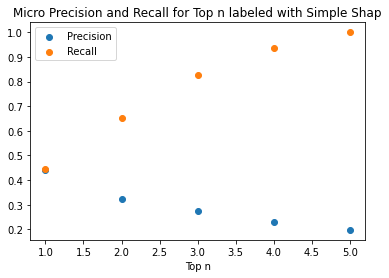

In [53]:
plt.scatter(np.arange(1,6), prec_vals, label='Precision')
plt.scatter(np.arange(1,6), rec_vals, label='Recall')
plt.legend()
plt.xlabel('Top n')
plt.title('Micro Precision and Recall for Top n labeled with Simple Shap')

In [56]:
def threshold_occlusion(threshold, average_type='weighted'):
    shap_array=np.array(test_csv[test_csv.columns[4:11]])
    robo_array=np.array(test_csv[test_csv.columns[20:]])
    robo, occlusion=post_process_flags(robo_array, shap_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
       # print(tce)
        occlusion[index]=np.where(occlusion[index]>threshold, 1, 0)
        
    #$print(occlusion)
    weighted_prec=precision_score(robo, occlusion, average=average_type, zero_division=0)
    weighted_rec=recall_score(robo,occlusion, average=average_type, zero_division=0)
    return weighted_prec, weighted_rec

In [59]:
prec_vals=[]
rec_vals=[]
for i in np.linspace(0, 1, 5000):
    prec, rec=threshold_occlusion(i)
    prec_vals.append(prec)
    rec_vals.append(rec)

Text(0.5, 1.0, 'Weighted Precision and Recall vs. Threshold for Simple Shap')

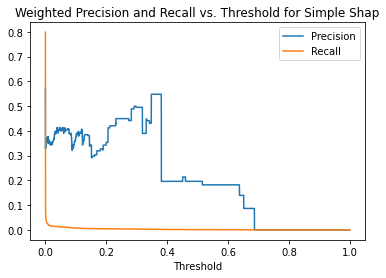

In [65]:
plt.plot(np.linspace(0, 1, 5000), prec_vals, label='Precision')
plt.plot(np.linspace(0, 1, 5000), rec_vals, label='Recall')
plt.legend()
#plt.ylim([0, 1])
plt.xlabel('Threshold')
plt.title('Weighted Precision and Recall vs. Threshold for Simple Shap')

In [66]:
prec_vals=[]
rec_vals=[]
for i in np.logspace(-10, 0, 5000):
    prec, rec=threshold_occlusion(i)
    prec_vals.append(prec)
    rec_vals.append(rec)

Text(0.5, 1.0, 'Weighted Precision and Recall vs. Threshold for Simple Shap')

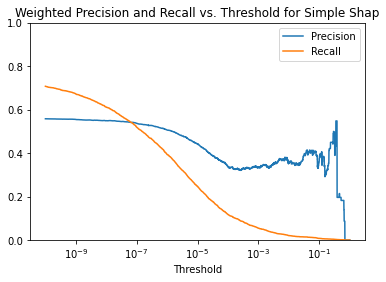

In [68]:
plt.plot(np.logspace(-10, 0, 5000), prec_vals, label='Precision')
plt.plot(np.logspace(-10, 0, 5000), rec_vals, label='Recall')
plt.legend()
plt.xscale('log')
plt.ylim([0, 1])
plt.xlabel('Threshold')
plt.title('Weighted Precision and Recall vs. Threshold for Simple Shap')

Issue of what if no branches are flagged by Robovetter? 
1) should we change/add a new metric to look only at cases where robovetter flags something
2) should we change the way we're doing this by introducing a threshold so that it can be completely analogous to the way we're doing our explainability?
3) should we add a new metric to analyze our explainability with where we only look at the maximally contributing branch in every case?

# Percentage of cases where there is at least one robovetter flag on that the maximally contributing branch (found via occlusion) agrees with one of the Robovetter flags

In [26]:
occlusion_array=np.array(test_csv[test_csv.columns[8:15]])
robo_array=np.array(test_csv[test_csv.columns[24:]])
num=0
denom=0
for index in range(len(occlusion_array)):
    tce=occlusion_array[index]
    max_contrib=np.argmax(tce)
    #print(max_contrib)
    robo_flags_on=np.where(robo_array[index]==1)[0]
    if (np.shape(robo_flags_on)[0]>0):
        denom=denom+1
        if (max_contrib in robo_flags_on):
            num=num+1
        elif (1 in robo_flags_on):
            if (max_contrib==0):
                num=num+1
print(num/denom)

0.5834677419354839


# Percentage of cases where there is at least one robovetter flag on that the top two maximally contributing branch (found via occlusion) agrees with one of the Robovetter flags

In [36]:
occlusion_array=np.array(test_csv[test_csv.columns[8:15]])
robo_array=np.array(test_csv[test_csv.columns[24:]])
num=0
denom=0
for index in range(len(occlusion_array)):
    tce=occlusion_array[index]
    max_contrib=np.argsort(tce)[-2:]
    robo_flags_on=np.where(robo_array[index]==1)[0]
    
    if (np.shape(robo_flags_on)[0]>0):
        denom=denom+1
        common_flags=np.intersect1d(robo_flags_on, max_contrib)
        if (np.shape(common_flags)[0]>0):
            num=num+1
        elif (1 in robo_flags_on):
            #print(robo_flags_on)
            if (0 in max_contrib):
               # print(max_contrib)
                num=num+1
print(num/denom)

0.8330645161290322


## Comparison of Occlusion and Our Methodology

In [70]:
def apply_statistics(branches, files, num_PCs):
    new_csv=files[0].copy()
    new_csv.pop('Unnamed: 0')
    for branch in branches:
        all_scores=np.zeros(tuple((num_PCs, np.shape(files[0])[0])))
        for example in range(len(files)):
            all_scores[example]=files[example][branch]
        col_index=new_csv.columns.get_loc(branch)
        new_csv[branch]=np.mean(all_scores, axis=0)
        new_csv.insert(col_index+1, branch+' Std', np.std(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Max', np.max(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Min', np.min(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Med', np.median(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Mean+Std', np.mean(all_scores, axis=0)+np.std(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Mean-Std', np.mean(all_scores, axis=0)-np.std(all_scores, axis=0))
    return new_csv



def evaluate_mean(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]]<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'], 'minor_flags':csv['Minor_Descriptive_Flags'],'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_min(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Min']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_max(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Max']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_med(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Med']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict


In [85]:
def get_csv_with_stat(num_PCs, trial):
    run='/nobackup/khauskne/kdd/explainability_runs/exp_'+str(num_PCs)+'_PCs_trial_'+str(trial)+'/'
    all_train_groups=[]
    for index in range(num_PCs):
        train_group=pd.read_csv(run+'train_top_'+str(index)+'.csv')
        all_train_groups.append(train_group)
    

    all_val_groups=[]
    for index in range(num_PCs):
        val_group=pd.read_csv(run+'val_top_'+str(index)+'.csv')
        all_val_groups.append(val_group)

    all_test_groups=[]
    for index in range(num_PCs):
        test_group=pd.read_csv(run+'test_top_'+str(index)+'.csv')
        all_test_groups.append(test_group)

    branches=['Global Flux', 'Local Flux', 'Centroid', 'Odd Even', 'Secondary', 'Stellar', 'DV']
    train_statistics=apply_statistics(branches, all_train_groups, num_PCs)
    val_statistics=apply_statistics(branches, all_val_groups, num_PCs)
    test_statistics=apply_statistics(branches, all_test_groups, num_PCs)
    return train_statistics[['Global Flux Min', 'Local Flux Min', 'Centroid Min', 'Odd Even Min',
                                         'Secondary Min', 'Stellar Min', 'DV Min']], val_statistics[['Global Flux Min', 'Local Flux Min', 'Centroid Min', 'Odd Even Min',
                                         'Secondary Min', 'Stellar Min', 'DV Min']], test_statistics[['Global Flux Min', 'Local Flux Min', 'Centroid Min', 'Odd Even Min',
                                         'Secondary Min', 'Stellar Min', 'DV Min']]

In [159]:
num_PCs=np.shape(np.where(test_csv['original_label']=='PC')[0])[0]
total_test=np.shape(test_csv)[0]
threshold_vals=np.logspace(-9, 0, 1000)

In [160]:
num_flagged=[]
for i in threshold_vals:
    threshold_flagged=np.shape(np.unique(np.where(test_csv[test_csv.columns[8:15]]>i)[0]))[0]
    num_flagged.append(threshold_flagged)
num_flagged=np.array(num_flagged)

In [161]:
test_new_exp=get_csv_with_stat(15, 2)[2]

In [162]:
num_flagged_new_exp=[]
for i in threshold_vals:
    threshold_flagged=np.shape(np.unique(np.where(test_new_exp<-1*i)[0]))[0]
    num_flagged_new_exp.append(threshold_flagged)
num_flagged_new_exp=np.array(num_flagged_new_exp)

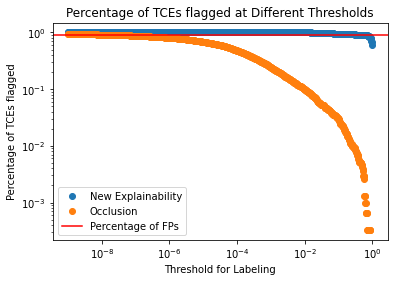

In [168]:
plt.title('Percentage of TCEs flagged at Different Thresholds')
plt.xlabel('Threshold for Labeling')
plt.ylabel('Percentage of TCEs flagged')



plt.loglog(threshold_vals, num_flagged_new_exp/total_test, 'o', label='New Explainability')
plt.loglog(threshold_vals, num_flagged/total_test, 'o', label='Occlusion')
plt.axhline(1-(num_PCs/total_test), color='r', label='Percentage of FPs')
plt.legend()
#plt.scatter(threshold_vals, num_flagged_new_exp/total_test)
#plt.scatter(threshold_vals, num_flagged/total_test)


In [169]:
num_PCs=np.shape(np.where(test_csv['original_label']=='PC')[0])[0]
total_test=np.shape(test_csv)[0]
threshold_vals=np.linspace(0, 1, 10000)

In [170]:
num_flagged=[]
for i in threshold_vals:
    threshold_flagged=np.shape(np.unique(np.where(test_csv[test_csv.columns[8:15]]>i)[0]))[0]
    num_flagged.append(threshold_flagged)
num_flagged=np.array(num_flagged)

In [171]:
test_new_exp=get_csv_with_stat(10, 2)[2]

In [172]:
num_flagged_new_exp=[]
for i in threshold_vals:
    threshold_flagged=np.shape(np.unique(np.where(test_new_exp<-1*i)[0]))[0]
    num_flagged_new_exp.append(threshold_flagged)
num_flagged_new_exp=np.array(num_flagged_new_exp)

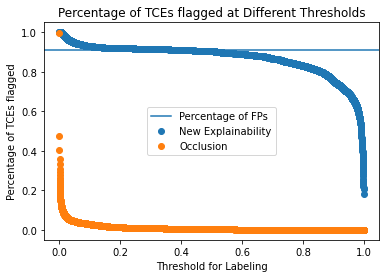

In [174]:
plt.title('Percentage of TCEs flagged at Different Thresholds')
plt.xlabel('Threshold for Labeling')
plt.ylabel('Percentage of TCEs flagged')

#plt.loglog(threshold_vals, num_flagged_new_exp/total_test, 'o')
#plt.loglog(threshold_vals, num_flagged/total_test, 'o')

plt.scatter(threshold_vals, num_flagged_new_exp/total_test, label='New Explainability')
plt.scatter(threshold_vals, num_flagged/total_test, label='Occlusion')
plt.axhline(1-(num_PCs/total_test), label='Percentage of FPs')
plt.legend()